In [2]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

from secrets import *

In [3]:
league_id = 84057
# I am team 10

In [4]:
dbname = 'cluj'
engine = create_engine('postgres://%s:%s@localhost/%s'%('docker','docker',dbname))

if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

True


In [5]:
url = 'https://fantasy.espn.com/apis/v3/games/FBA/seasons/2020/segments/0/leagues/' + str(league_id)
params={"view": "kona_player_info"}
cookies = {"swid": AUTH['swid'],
           "espn_s2": AUTH['espn_s2']}
r = requests.get(url, params=params, cookies=cookies)
data = r.json()
data.keys()

dict_keys(['players'])

In [6]:
stat_list = []
team_id_list = []
for player in data['players']:
    #print(player['player']['fullName'])
    for stat_item in player['player']['stats']:
        #looks like season totals AND averages id = '002020'
        if stat_item['id'] == '002020':
            if '40' in stat_item['stats'].keys(): # '40' is minutes
                stat_item['stats']['playerName'] = player['player']['fullName']
                stat_list.append(stat_item['stats'])
                team_id_list.append(player['onTeamId'])

In [7]:
stats_df = pd.DataFrame(stat_list)
stats_df['onTeamId'] = team_id_list
stats_df.shape

(461, 46)

In [8]:
col_rename_dict = {'0':'pts', '1':'blocks', '2':'steals', '3':'ast', '6':'reb', '13':'fgm', '14': 'fga', 
                   '15': 'ftm', '16':'fta', '17':'threes', '40':'min', '42':'gp'}
stats_df.rename(columns=col_rename_dict, inplace=True)
stats_df['fg_pct'] = stats_df['fgm'] / stats_df['fga']
stats_df['ft_pct'] = stats_df['ftm'] / stats_df['fta']
stats_df = stats_df[['playerName','onTeamId','pts','blocks','steals','ast','reb','fgm','fga','fg_pct','ftm','fta','ft_pct','threes','min','gp']]

In [9]:
stats_df.head()

,playerName,onTeamId,pts,blocks,steals,ast,reb,fgm,fga,fg_pct,ftm,fta,ft_pct,threes,min,gp
0,Vince Carter,0,150.0,13.0,9.0,32.0,60.0,54.0,167.0,0.323353,12.0,17.0,0.705882,30.0,494.0,32.0
1,Tyson Chandler,0,34.0,8.0,6.0,6.0,63.0,14.0,18.0,0.777778,6.0,13.0,0.461538,0.0,209.0,23.0
2,LeBron James,6,939.0,20.0,48.0,397.0,296.0,359.0,735.0,0.488435,141.0,204.0,0.691176,80.0,1292.0,37.0
3,Carmelo Anthony,12,406.0,15.0,26.0,29.0,152.0,153.0,356.0,0.429775,60.0,73.0,0.821918,40.0,791.0,25.0
4,Kyle Korver,0,213.0,7.0,16.0,43.0,64.0,68.0,170.0,0.400000,21.0,24.0,0.875000,56.0,574.0,35.0


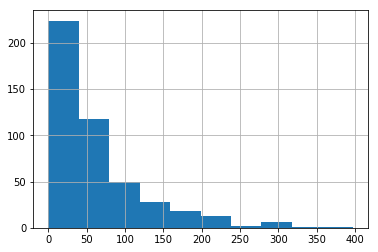

In [10]:
stats_df['ast'].hist()

In [11]:
stats_df.loc[:,'ast_rank'] = stats_df.apply(lambda x: ( (x['ast'] - stats_df['ast'].mean()) / stats_df['ast'].std()) , axis = 1)
stats_df.loc[:,'blocks_rank'] = stats_df.apply(lambda x: ( (x['blocks'] - stats_df['blocks'].mean()) / stats_df['blocks'].std()) , axis = 1)
stats_df.loc[:,'steals_rank'] = stats_df.apply(lambda x: ( (x['steals'] - stats_df['steals'].mean()) / stats_df['steals'].std()) , axis = 1)
stats_df.loc[:,'reb_rank'] = stats_df.apply(lambda x: ( (x['reb'] - stats_df['reb'].mean()) / stats_df['reb'].std()) , axis = 1)
stats_df.loc[:,'pts_rank'] = stats_df.apply(lambda x: ( (x['pts'] - stats_df['pts'].mean()) / stats_df['pts'].std()) , axis = 1)
stats_df.loc[:,'threes_rank'] = stats_df.apply(lambda x: ( (x['threes'] - stats_df['threes'].mean()) / stats_df['threes'].std()) , axis = 1)
stats_df.loc[:,'fta_rank'] = stats_df.apply(lambda x: ( (x['fta'] - stats_df['fta'].mean()) / stats_df['fta'].std()) , axis = 1)
stats_df.loc[:,'fga_rank'] = stats_df.apply(lambda x: ( (x['fga'] - stats_df['fga'].mean()) / stats_df['fga'].std()) , axis = 1)
stats_df.loc[:,'ft_pct_rank'] = stats_df.apply(lambda x: ( (x['ft_pct'] - stats_df['ft_pct'].mean()) / stats_df['ft_pct'].std()) , axis = 1)
stats_df.loc[:,'fg_pct_rank'] = stats_df.apply(lambda x: ( (x['fg_pct'] - stats_df['fg_pct'].mean()) / stats_df['fg_pct'].std()) , axis = 1)
stats_df['fg_rank_adj'] = stats_df['fg_pct_rank'] * stats_df['fga_rank']
stats_df['ft_rank_adj'] = stats_df['ft_pct_rank'] * stats_df['fta_rank']

cat_ranks = ['ast_rank','blocks_rank','steals_rank','reb_rank','pts_rank','threes_rank','fg_rank_adj','ft_rank_adj']
stats_df['total_rank'] = stats_df[cat_ranks].sum(axis=1)
stats_df.sort_values('total_rank', inplace=True, ascending= False)

final_stats_df = stats_df[['playerName','onTeamId','total_rank'] + cat_ranks]

In [12]:
# how to properly account for fga and fta in their ranks? Did what I did make sense? doesn't appear to match up well with website
# do I need to remove anyone when I calculate the ranks?


In [13]:
my_team = final_stats_df.loc[final_stats_df.onTeamId==10]
my_team = my_team.loc[my_team.playerName != 'Jonathan Isaac'] # how to remove players on IR
my_team

,playerName,onTeamId,total_rank,ast_rank,blocks_rank,steals_rank,reb_rank,pts_rank,threes_rank,fg_rank_adj,ft_rank_adj
221,Giannis Antetokounmpo,10,12.326399,2.327098,1.813588,1.687541,3.844680,3.527029,1.055061,2.488075,-4.416673
264,Nikola Jokic,10,10.980785,2.825485,0.483758,1.056185,2.630356,1.874937,0.670518,0.960325,0.479220
193,Buddy Hield,10,7.773079,0.940961,-0.048174,0.740507,0.880908,2.114490,3.586638,-0.740684,0.298433
119,Tomas Satoransky,10,5.763592,2.342673,-0.447123,2.318896,0.345782,0.507830,0.510291,-0.004305,0.189546
391,Miles Bridges,10,5.043488,0.224531,1.215165,0.361694,1.169052,0.953895,1.055061,0.004567,0.059523
252,Julius Randle,10,4.881363,0.925387,-0.247648,0.487965,2.280467,1.672556,0.446201,-0.003683,-0.679880
46,Derrick Rose,10,4.811100,2.109054,-0.114665,0.614236,-0.364288,1.350398,0.125748,0.515906,0.574711
190,Taurean Prince,10,4.722444,0.286829,0.284284,0.929914,1.374870,0.726733,1.952329,-0.761408,-0.071106
430,PJ Washington,10,4.430964,0.146658,1.348148,0.866778,0.839744,0.689561,0.606427,0.185409,-0.251760
397,Markelle Fultz,10,3.626987,1.735265,-0.380631,1.940083,0.057638,0.631737,-0.419021,0.053629,0.008289


In [14]:
my_team[cat_ranks].sum()

ast_rank       13.151395
blocks_rank     9.081500
steals_rank    12.278288
reb_rank       14.539063
pts_rank       14.552490
threes_rank     9.485818
fg_rank_adj     1.465658
ft_rank_adj    -3.613412
dtype: float64